In [101]:

# ---------------------------------------------------------------------
#Modèle 1 : Modèle de TCO avec charge salariale et sans coûts de réseau
# ---------------------------------------------------------------------


#!/usr/bin/env python3
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt

# 0) CHEMINS à adapter
yaml_path  = "/MOVHY_REVSOLUTION_ETUDES/modele_TCO/hypotheses_de_base.yaml"
output_dir = "/Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_results_with_salary"
os.makedirs(output_dir, exist_ok=True)

# 1) Lecture du YAML et extraction des blocs
with open(yaml_path, "r") as f:
    cfg = yaml.safe_load(f)

# On retire d'abord defaults et network
defaults        = cfg.pop("defaults", {})
raw_network     = cfg.pop("network", {})

# → On retire aussi les blocs de “profil” et de “pricing”
_ = cfg.pop("usage_profiles", None)       # utile pour Modèle 3, pas ici
_ = cfg.pop("Hydrogene_pricing", None)    # idem

# À ce stade cfg ne contient plus QUE les 4 motorisations
# (Diesel, Electrique, Hydrogene, Retrofit_Electrique)

# On applique les valeurs par défaut à chaque techno
for techno, params in cfg.items():
    for k, v in defaults.items():
        params.setdefault(k, v)

# Enfin on construit l’objet utilisé pour le TCO par véhicule
hypotheses_vehicle = cfg

# 2) Fonction de calcul du TCO par véhicule
def compute_tco_vehicle(params):
    N         = params["contract_years"]
    r         = params["discount_rate"]
    annual_km = params["km_per_day"] * params["annual_days"]
    total_km  = annual_km * N

    # Flux initial (CAPEX + infra – résiduelle)
    flux0 = params["invest_net"] + params["infra_cost"] - params["residual_value"]

    # postes annuels
    base_cost   = params["leasing_annual"] or (params["invest_net"] / N)
    energy_cost = (params["consumption_100km"] / 100) * annual_km * params["energy_price"]
    maint       = params["maintenance_annual"]
    assur       = params["assurance"]
    co2_cost    = (params["emission_g_per_km"] / 1_000_000) * annual_km * params["co2_tax_rate"]

    # **Charge salariale** (main-d’œuvre conducteur)
    labor_cost  = params["labor_cost_per_h"] * params["labor_hours_day"] * params["annual_days"]

    # Flux annuel total
    annual_flux = (
        base_cost
      + energy_cost
      + maint
      + assur
      + co2_cost
      + labor_cost       # <-- ici on l’ajoute
    )

    # Liste des flux t=0…N
    cash_flows = [flux0] + [annual_flux] * N
    # Actualisation
    discounted = [cf / ((1 + r) ** t) for t, cf in enumerate(cash_flows)]

    return {
        "TCO brut (€)":          sum(cash_flows),
        "TCO actualisé (€)":     sum(discounted),
        "Coût €/km brut":        sum(cash_flows) / total_km,
        "Coût €/km actualisé":   sum(discounted) / total_km
    }

# 3) Reporting : DataFrame, Excel & graphiques
def plot_bar(df, col, title, fname):
    fig, ax = plt.subplots(figsize=(6,4))
    df[col].plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(col)
    ax.set_xticklabels(df.index, rotation=45)
    plt.tight_layout()
    path = os.path.join(output_dir, fname)
    fig.savefig(path)
    plt.close(fig)
    print(f"→ Graphique sauvegardé : {path}")

def generate_report():
    # 1. Calculs uniquement pour les motorisations
    results = {
        tech: compute_tco_vehicle(params)
        for tech, params in hypotheses_vehicle.items()
    }
    df = pd.DataFrame(results).T
    print(df.to_string(float_format="%.2f"))

    # 2. Export Excel
    excel_path = os.path.join(output_dir, "TCO_vehicle_only.xlsx")
    df.to_excel(excel_path, sheet_name="TCO Véhicule")
    print(f"→ Excel généré : {excel_path}")

    # 3. Graphiques comparatifs
    sample = next(iter(hypotheses_vehicle.values()))
    total_km = sample["km_per_day"] * sample["annual_days"] * sample["contract_years"]

    plot_bar(df, "TCO brut (€)",            f"TCO brut sur {total_km:,} km",        "TCO_brut.png")
    plot_bar(df, "TCO actualisé (€)",       f"TCO actualisé sur {total_km:,} km",   "TCO_actualise.png")
    plot_bar(df, "Coût €/km brut",          "Coût moyen par km (brut)",           "Cout_km.png")
    plot_bar(df, "Coût €/km actualisé",     "Coût moyen par km (actualisé)",      "Cout_km_actualise.png")

# 4) Point d’entrée
if __name__ == "__main__":
    generate_report()

                     TCO brut (€)  TCO actualisé (€)  Coût €/km brut  Coût €/km actualisé
Diesel                  781548.00          609641.96            1.74                 1.35
Electrique              776103.00          610430.30            1.72                 1.36
Hydrogene               872675.00          692815.09            1.94                 1.54
Retrofit_Electrique     553054.40          450463.40            1.54                 1.25
→ Excel généré : /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_results_with_salary/TCO_vehicle_only.xlsx
→ Graphique sauvegardé : /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_results_with_salary/TCO_brut.png
→ Graphique sauvegardé : /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_results_with_salary/TCO_actualise.png
→ Graphique sauvegardé : /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLU

In [220]:
# ---------------------------------------------------------------------
#Modèle 2 : Modèle de TCO sans charge salariale et sans coûts de réseau
# ---------------------------------------------------------------------


# ---------------------------------------------------------------------
# 0) Chemins à ajuster
# ---------------------------------------------------------------------
# Chemin vers votre fichier YAML d’hypothèses
yaml_path   = "/MOVHY_REVSOLUTION_ETUDES/modele_TCO/hypotheses_de_base.yaml"
# Dossier de sortie pour Excel et PNG (à modifier selon votre arborescence)
output_dir  = "/Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_results_without_salary"

# Crée le dossier de sortie s’il n’existe pas
os.makedirs(output_dir, exist_ok=True)

# ---------------------------------------------------------------------
# 1) Chargement du YAML et fusion des defaults
# ---------------------------------------------------------------------
with open(yaml_path, "r") as f:
    cfg = yaml.safe_load(f)

# Retirer defaults et network
defaults      = cfg.pop("defaults", {})
_             = cfg.pop("network", {})

# Retirer les blocs de profil ou pricing (venus du Modèle 3)
_             = cfg.pop("usage_profiles", None)
_             = cfg.pop("Hydrogene_pricing", None)
_             = cfg.pop("fleet_sizes", None)

# Ici, cfg ne contient PLUS que les 4 techno
for techno, params in cfg.items():
    for k, v in defaults.items():
        params.setdefault(k, v)

hypotheses_vehicle = cfg  # {'Diesel':…, 'Electrique':…, 'Hydrogene':…, 'Retrofit_Electrique':…}

# Debug : vérifiez bien la présence de 'contract_years'
for tech, params in hypotheses_vehicle.items():
    print(f"{tech} → clés = {list(params.keys())}")
# Debug : affichez pour chaque techno les clés de son dict
for tech, params in hypotheses_vehicle.items():
    print(f"Clés pour {tech} : {list(params.keys())}")

# ---------------------------------------------------------------------
# 2) Fonction de calcul du TCO (véhicule seul)
# ---------------------------------------------------------------------
def compute_tco_vehicle(params):
    """
    Calcule :
      - TCO brut
      - TCO actualisé (taux = params['discount_rate'])
      - Coût €/km brut
      - Coût €/km actualisé
    en n’incluant PAS le coût de la main-d’œuvre.
    """
    N        = params["contract_years"]
    r        = params["discount_rate"]
    annual_km = params["km_per_day"] * params["annual_days"]
    total_km  = annual_km * N

    # Flux 0 : CAPEX + infra – valeur résiduelle
    flux0 = params["invest_net"] + params["infra_cost"] - params["residual_value"]

    # Poste fixe annuel : leasing ou amortissement linéaire
    base_cost    = params["leasing_annual"] or (params["invest_net"] / N)
    # Poste énergie
    energy_cost  = (params["consumption_100km"]/100) * annual_km * params["energy_price"]
    # Maintenance, assurance, taxe CO₂
    maintenance  = params["maintenance_annual"]
    assurance    = params["assurance"]
    co2_cost     = (params["emission_g_per_km"]/1_000_000) * annual_km * params["co2_tax_rate"]

    # Flux annuel récurrent
    annual_flux = base_cost + energy_cost + maintenance + assurance + co2_cost

    # Construction des flux et actualisation
    cash_flows    = [flux0] + [annual_flux] * N
    discounted    = [cf / ((1 + r) ** t) for t, cf in enumerate(cash_flows)]

    # Agrégats
    tco_brut      = sum(cash_flows)
    tco_actualise = sum(discounted)
    cost_per_km   = tco_brut / total_km
    cost_per_km_act = tco_actualise / total_km

    return {
        "TCO brut (€)":            tco_brut,
        "TCO actualisé (€)":       tco_actualise,
        "Coût €/km":               cost_per_km,
        "Coût €/km actualisé":     cost_per_km_act
    }

# ---------------------------------------------------------------------
# 3) Reporting : DataFrame, Excel & graphiques
# ---------------------------------------------------------------------
def plot_and_save(df, column, title, fname):
    fig, ax = plt.subplots(figsize=(6,4))
    df[column].plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(column)
    ax.set_xticklabels(df.index, rotation=45)
    fig.tight_layout()
    path = os.path.join(output_dir, fname)
    fig.savefig(path)
    plt.close(fig)

# ---------------------------------------------------------------------
# Sélectionne uniquement les vraies motorisations
# ---------------------------------------------------------------------
tech_list = [t for t in hypotheses_vehicle.keys()
             if t not in ("defaults", "network")]

# ---------------------------------------------------------------------
# Fonction de reporting mise à jour
# ---------------------------------------------------------------------
def generate_report():
    # 1) Calcul des TCO par techno
    results = {
        tech: compute_tco_vehicle(hypotheses_vehicle[tech])
        for tech in tech_list
    }
    df = pd.DataFrame(results).T
    print(df.to_string(float_format="%.2f"))

    # 2) Export Excel
    excel_path = os.path.join(output_dir, "TCO_vehicle_only.xlsx")
    df.to_excel(excel_path, sheet_name="TCO Véhicule")
    print(f"→ Excel généré : {excel_path}")

    # 3) Graphiques
    sample = hypotheses_vehicle[tech_list[0]]
    total_km = sample["km_per_day"] * sample["annual_days"] * sample["contract_years"]

    plot_and_save(df, "TCO brut (€)",
                  f"TCO brut sur {total_km:,} km",
                  "TCO_brut.png")
    plot_and_save(df, "TCO actualisé (€)",
                  f"TCO actualisé sur {total_km:,} km",
                  "TCO_actualise.png")
    plot_and_save(df, "Coût €/km",
                  "Coût moyen par km (brut)",
                  "Cout_km.png")
    plot_and_save(df, "Coût €/km actualisé",
                  "Coût moyen par km (actualisé)",
                  "Cout_km_actualise.png")

# ---------------------------------------------------------------------
# 4) Point d’entrée
# ---------------------------------------------------------------------
if __name__ == "__main__":
    generate_report()

Diesel → clés = ['invest_net', 'leasing_annual', 'residual_value', 'contract_years', 'infra_cost', 'consumption_100km', 'energy_price', 'maintenance_annual', 'assurance', 'co2_tax_rate', 'emission_g_per_km', 'embedded_emissions_tCO2', 'annual_days', 'km_per_day', 'labor_hours_day', 'labor_cost_per_h', 'discount_rate']
Electrique → clés = ['invest_net', 'leasing_annual', 'residual_value', 'contract_years', 'infra_cost', 'consumption_100km', 'energy_price', 'maintenance_annual', 'assurance', 'co2_tax_rate', 'emission_g_per_km', 'embedded_emissions_tCO2', 'grid_emission_factor_kgCO2_per_kWh', 'annual_days', 'km_per_day', 'labor_hours_day', 'labor_cost_per_h', 'discount_rate']
Hydrogene → clés = ['invest_net', 'leasing_annual', 'residual_value', 'contract_years', 'infra_cost', 'consumption_100km', 'energy_price', 'maintenance_annual', 'assurance', 'co2_tax_rate', 'emission_g_per_km', 'embedded_emissions_tCO2', 'h2_upstream_emission_kgCO2_per_kg', 'annual_days', 'km_per_day', 'labor_hours_d

→ Excel généré → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_result_with_network/TCO_fleet_network.xlsx
→ Graphique → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_result_with_network/Coût €_km actu + réseau.png
→ Graphique → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_result_with_network/Coût €_km brut + réseau.png
→ Graphique → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_result_with_network/TCO actu + réseau (€).png
→ Graphique → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_result_with_network/TCO brut + réseau (€).png
→ Excel profils×filières généré : TCO_by_profile_filiere.xlsx
→ Graphique 'TCO brut + réseau (€)' → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_result_with_network/TCO_brut_+_réseau_

<Figure size 800x500 with 0 Axes>

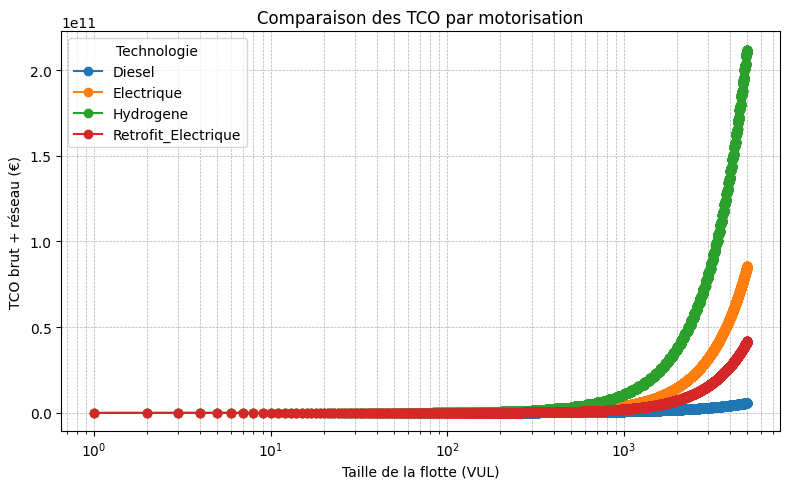

In [230]:

# ---------------------------------------------------------------------
#Modèle 3 : Modèle de TCO sans charge salariale et avec coûts de réseau
# ---------------------------------------------------------------------

import os
import math
import yaml
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from numpy_financial import irr, npv
import pulp
from functools import lru_cache
from pathlib import Path


# ----------------------------------
# 0) CHEMINS À ADAPTER
# ----------------------------------
yaml_path  = Path("/Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/hypotheses.yaml")
output_dir = Path("/Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_result_with_network")
os.makedirs(output_dir, exist_ok=True)


# Tailles de flotte à analyser
fleet_sizes = list(range(1, 5001))

def normalize_key(s: str) -> str:
    nfkd = unicodedata.normalize("NFD", s)
    ascii_only = nfkd.encode("ascii", "ignore").decode("ascii")
    return (ascii_only.replace(" ", "_")
                     .replace("-", "_")
                     .replace("/", "_")
                     .replace("\\", "_"))

def cast_numeric(v):
    if isinstance(v, str):
        try: return int(v)
        except:
            try: return float(v)
            except: return v
    if isinstance(v, dict):
        return {k: cast_numeric(val) for k,val in v.items()}
    return v

# ------------------------------
# 1) Lecture YAML & préparation
# ------------------------------
def load_hypotheses(yaml_path):
    with open(yaml_path, "r") as f:
        cfg = yaml.safe_load(f)
    defaults          = cfg.pop("defaults", {})
    raw_network       = cfg.pop("network", {})
    usage_profiles    = cfg.pop("usage_profiles", {})
    hydrogene_pricing = cfg.pop("Hydrogene_pricing", {})
    _                 = cfg.pop("fleet_sizes", None)
    fleet_sizes       = cfg.pop("fleet_sizes", list(range(1,5001)))
    # apply defaults
    for tech, params in cfg.items():
        for k,v in defaults.items():
            params.setdefault(k, v)
    # build network_cfg
    network_cfg = {normalize_key(k): cast_numeric(v) for k,v in raw_network.items()}
    # validate numeric
    for tech, block in network_cfg.items():
        for field,val in block.items():
            if not isinstance(val, (int,float)):
                raise TypeError(f"Champ réseau {field} pour {tech} doit être un nombre")
    return cfg, fleet_sizes, usage_profiles, hydrogene_pricing, network_cfg

# ------------------------------
# 2) TCO véhicule
# ------------------------------
def compute_tco_vehicle(p: dict) -> tuple[float,float]:
    N = p["contract_years"]; r = p["discount_rate"]
    annual = p["km_per_day"] * p["annual_days"]
    flux0 = p["invest_net"] + p["infra_cost"] - p["residual_value"]
    base = p["leasing_annual"] or (p["invest_net"]/N)
    energy = p["consumption_100km"]/100 * annual * p["energy_price"]
    maint, assur = p["maintenance_annual"], p["assurance"]
    co2 = p["emission_g_per_km"]/1e6 * annual * p["co2_tax_rate"]
    ann = base + energy + maint + assur + co2
    flows = [flux0] + [ann]*N
    disc = [cf/((1+r)**t) for t,cf in enumerate(flows)]
    return sum(flows), sum(disc)

# ------------------------------
# 3) Coûts réseau
# ------------------------------
@lru_cache(maxsize=None)
def compute_network_cost(tech: str, size: int) -> float:
    key = normalize_key(tech)
    net = network_cfg.get(key, {})
    if not net:
        return 0.0

    # Diesel
    if "pump_station_base_cost" in net:
        pumps = math.ceil(size / net["pump_capacity_vehicles"])
        return (
            net["connection_cost"]
          + net["pump_station_base_cost"]
          + pumps * net["pump_unit_cost"]
          + net["piping_cost_per_meter"] * net["avg_piping_length_m"]
          + net["permit_cost"]
          + pumps * net["installation_labor_cost_per_pump"]
        )

    # Électrique
    if "transformer_upgrade_cost" in net and "charger_capacity_vehicles" in net:
        chargers = math.ceil(size / net["charger_capacity_vehicles"])
        return (
            net["transformer_upgrade_cost"]
          + chargers * net["charger_unit_cost"]
          + net["cable_cost_per_meter"] * net["avg_cable_length_m"] * chargers
          + chargers * net["installation_labor_cost_per_charger"]
          + net["demand_charge_per_kW"] * net["charger_power_kW"] * chargers
          + net["network_service_fee_per_year"]
        )

    # Hydrogène
    if "base_station_cost" in net and "module_capacity_vehicles" in net:
        modules    = math.ceil(size / net["module_capacity_vehicles"])
        dispensers = math.ceil(size / net["dispenser_capacity_vehicles"])
        return (
            net["base_station_cost"]
          + modules * net["module_unit_cost"]
          + dispensers * net["dispenser_unit_cost"]
          + net["safety_system_cost"]
          + net["permit_cost"]
          + net["installation_labor_cost"]
        )

    return 0.0

# actualisé OPEX réseau
def compute_full_network_cost(
    tech: str,
    size: int,
    include_opex: bool
) -> tuple[float, float]:
    capex = compute_network_cost(tech, size)

    # récupère l’OPEX annuel dans la cfg globale
    key = normalize_key(tech)
    opex_annuel = network_cfg.get(key, {}).get("network_opex_annual", 0.0)
    opex_disc = 0.0

    if include_opex and opex_annuel:
        p = hypotheses[key]
        r = p["discount_rate"]
        N = p["contract_years"]
        opex_disc = sum(opex_annuel / ((1 + r) ** t) for t in range(1, N + 1))

    return capex, opex_disc

# ------------------------------
# 4) TCO véhicule + réseau
# ------------------------------
def compute_tco_with_network_opex(params: dict, tech: str, include_opex: bool,
                                   size: int=1) -> dict:
    tco_b, tco_a = compute_tco_vehicle(params)
    capex, opex = compute_full_network_cost(tech, size, include_opex)
    # brut
    tco_b += capex + opex*params["contract_years"]
    # actualisé
    if include_opex and opex:
        r = params["discount_rate"]
        opex_actu = sum(opex/((1+r)**t) for t in range(1, params["contract_years"]+1))
        tco_a += capex + opex_actu
    else:
        tco_a += capex
    km_tot = params["km_per_day"]*params["annual_days"]*params["contract_years"]
    return {
        "TCO brut + réseau (€)":     tco_b,
        "TCO actu + réseau (€)":     tco_a,
        "Coût €/km brut + réseau":   tco_b/km_tot,
        "Coût €/km actu + réseau":   tco_a/km_tot,
    }

# ------------------------------
# 5) Export & plotting
# ------------------------------
def sanitize_sheet_name(name: str) -> str:
    return re.sub(r'[\/\\?\*\[\]\:]', '_', name)[:31]

def export_and_plot_fleet(df_fleet: pd.DataFrame, output_dir: Path):
    output_dir.mkdir(parents=True, exist_ok=True)
    # Excel + pivots
    excel_path = output_dir/"TCO_fleet_network.xlsx"
    with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
        df_fleet.to_excel(writer, sheet_name="Flottes_brut", index=False)
        for metric in df_fleet.columns.difference(["Techno","Flotte"]):
            df_fleet.pivot(index="Flotte", columns="Techno", values=metric).to_excel(writer, sheet_name=sanitize_sheet_name(metric))
    print(f"→ Excel généré → {excel_path}")
    # Graphiques log-scale
    for metric in df_fleet.columns.difference(["Techno","Flotte"]):
        plt.figure(figsize=(6,4))
        for tech in df_fleet["Techno"].unique():
            sub = df_fleet[df_fleet["Techno"]==tech]
            plt.plot(sub["Flotte"], sub[metric], 'o-', label=tech)
        plt.xscale('log'); plt.xlabel("Flotte"); plt.ylabel(metric)
        plt.title(metric); plt.grid(True, ls='--', lw=0.5); plt.legend()
        png = output_dir/f"{sanitize_sheet_name(metric)}.png"
        plt.tight_layout(); plt.savefig(png); plt.close()
        print(f"→ Graphique → {png}")

# ------------------------------
# Main
# ------------------------------
if __name__ == "__main__":
    yaml_path = Path("/Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/hypotheses.yaml")
    output_dir = Path("/Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/TCO_result_with_network")
    hypotheses, fleet_sizes, usage_profiles, hydrogene_pricing, network_cfg = \
        load_hypotheses(yaml_path)
    # Construction DataFrame flotte
    rows = []
    for tech, params in hypotheses.items():
        for N in fleet_sizes:
            unit = compute_tco_with_network_opex(params, tech, True, size=N)
            rows.append({
                'Techno': tech,
                'Flotte': N,
                **{k: (v*N if 'TCO brut' in k or 'TCO actu' in k else v)
                   for k,v in unit.items()}
            })
    df_fleet = pd.DataFrame(rows)
    export_and_plot_fleet(df_fleet, output_dir)
    # Profils Hydrogène
    df_prof = pd.DataFrame([
        {"Techno": tech, "Profil": prof, "Filière": fil,
         "TCO brut": b, "TCO actu": a}
        for tech, params in hypotheses.items()
        for prof, up in usage_profiles.items()
        for fil in ([None] if tech!="Hydrogene" else hydrogene_pricing)
        for b,a in ([compute_tco_vehicle({**params, **up, **({} if fil is None else {"energy_price": hydrogene_pricing[fil]})})])
    ])
    for mode in ["brut","actu"]:
        plt.figure(figsize=(8,4))
        for fil in df_prof["Filière"].dropna().unique():
            sub = df_prof[df_prof["Filière"]==fil]
            plt.plot(sub["Profil"], sub[f"TCO {mode}"], 'o-', label=fil)
        plt.title(f"TCO {mode} H₂ par profil & filière"); plt.legend(); plt.tight_layout()
        plt.savefig(output_dir/f"H2_TCO_{mode}_by_filiere.png"); plt.close()


def subsidy_schedule(params, drop=0.1):
    N = params["contract_years"]
    invest = params["invest_net"]
    return [invest * max(0, 1 - drop*t) for t in range(N+1)]

def compute_tco_with_replacement(params, swap_year=5, swap_cost=10000):
    N = params["contract_years"]
    r = params["discount_rate"]
    annual_km = params["km_per_day"] * params["annual_days"]

    # Flux0
    flux0 = params["invest_net"] + params["infra_cost"] - params["residual_value"]
    base  = params["leasing_annual"] or (params["invest_net"]/N)
    energy= (params["consumption_100km"]/100)*annual_km*params["energy_price"]
    maint = params["maintenance_annual"]
    assur = params["assurance"]
    co2   = (params["emission_g_per_km"]/1e6)*annual_km*params["co2_tax_rate"]

    cash_flows = [flux0]
    for t in range(1, N+1):
        ann = base + energy + maint + assur + co2
        if t == swap_year:
            ann += swap_cost
        cash_flows.append(ann)

    disc = [cf/((1+r)**t) for t, cf in enumerate(cash_flows)]
    return sum(cash_flows), sum(disc)

def compute_energy_cost_time_of_use(params, peak_factor=1.5):
    km = params["km_per_day"] * params["annual_days"]
    off_km  = km * 0.7
    peak_km = km * 0.3
    base = params["leasing_annual"] or (params["invest_net"]/params["contract_years"])
    energy_off  = (params["consumption_100km"]/100)*off_km*params["energy_price"]
    energy_peak = (params["consumption_100km"]/100)*peak_km*(params["energy_price"]*peak_factor)
    return energy_off + energy_peak

# ----------------------------------
# 4) CALCUL DES COÛTS RÉSEAU
# ----------------------------------

@lru_cache(maxsize=None)
def compute_tco_vehicle_cached(key: str):
    """Prend la clé normalisée (‘Diesel’, etc.) et renvoie (tco_b, tco_a)."""
    p = hypotheses[key]
    return compute_tco_vehicle(p)

# Ex. appel :
tco_b, tco_a = compute_tco_vehicle_cached(normalize_key("Electrique"))
def compute_network_cost(tech: str, size: int) -> float:
    key = normalize_key(tech)
    net = network_cfg.get(key, {})
    if not net:
        return 0.0

    # Diesel
    if "pump_station_base_cost" in net:
        pumps = math.ceil(size / net["pump_capacity_vehicles"])
        return (
            net["connection_cost"]
          + net["pump_station_base_cost"]
          + pumps * net["pump_unit_cost"]
          + net["piping_cost_per_meter"] * net["avg_piping_length_m"]
          + net["permit_cost"]
          + pumps * net["installation_labor_cost_per_pump"]
        )

    # Électrique & Retrofit
    if "transformer_upgrade_cost" in net and "charger_capacity_vehicles" in net:
        chargers = math.ceil(size / net["charger_capacity_vehicles"])
        return (
            net["transformer_upgrade_cost"]
          + chargers * net["charger_unit_cost"]
          + net["cable_cost_per_meter"] * net["avg_cable_length_m"] * chargers
          + chargers * net["installation_labor_cost_per_charger"]
          + net["demand_charge_per_kW"] * net["charger_power_kW"] * chargers
          + net["network_service_fee_per_year"]
        )

    # Hydrogène
    if "base_station_cost" in net and "module_capacity_vehicles" in net:
        modules    = math.ceil(size / net["module_capacity_vehicles"])
        dispensers = math.ceil(size / net["dispenser_capacity_vehicles"])
        return (
            net["base_station_cost"]
          + modules * net["module_unit_cost"]
          + dispensers * net["dispenser_unit_cost"]
          + net["safety_system_cost"]
          + net["permit_cost"]
          + net["installation_labor_cost"]
        )

    return 0.0

def compute_tco_with_inflation(params, inflation_energy=0.02, inflation_maint=0.01):
    N      = params["contract_years"]
    r      = params["discount_rate"]
    base   = params["leasing_annual"] or (params["invest_net"]/N)
    flux0  = params["invest_net"] + params["infra_cost"] - params["residual_value"]

    cash_flows = [flux0]
    for t in range(1, N+1):
        annual_km    = params["km_per_day"] * params["annual_days"]
        price_e      = params["energy_price"] * (1+inflation_energy)**(t-1)
        maint_cost   = params["maintenance_annual"]  * (1+inflation_maint)**(t-1)
        energy_cost  = (params["consumption_100km"]/100)*annual_km*price_e
        assur_cost   = params["assurance"]
        co2_cost     = (params["emission_g_per_km"]/1e6)*annual_km*params["co2_tax_rate"]
        ann          = base + energy_cost + maint_cost + assur_cost + co2_cost
        cash_flows.append(ann)

    discounted = [cf/((1+r)**t) for t, cf in enumerate(cash_flows)]
    return sum(cash_flows), sum(discounted)

def degressive_amortization(params, rate=0.4):
    """
    Remplace base_cost linéaire par un amortissement dégressif.
    rate: part amortie la 1ère année (ex. 0.4 = 40 %)
    """
    N      = params["contract_years"]
    capex  = params["invest_net"]
    book   = capex
    amort  = []
    for t in range(1, N+1):
        a = book * rate
        amort.append(a)
        book -= a
    # Si reste de book, étalez sur dernières années
    if len(amort)<N:
        rem = book
        amort += [rem/(N-len(amort))] * (N-len(amort))
    return amort  # liste de N amortissements par année

# Ajoutez dans vos YAML sous chaque techno, p.ex. network:"Electrique": {..., network_opex_annual: 2000}
# ---------------------------------------------------------------------
# 4.b) CAPEX + OPEX réseau (sans years en param)
# ---------------------------------------------------------------------
def compute_full_network_cost(
    tech: str,
    size: int,
    include_opex: bool = True
) -> tuple[float, float]:
    key = normalize_key(tech)
    capex = compute_network_cost(key, size)

    opex_annuel = network_cfg.get(key, {}).get("network_opex_annual", 0.0)
    opex_disc   = 0.0
    if include_opex and opex_annuel:
        params = hypotheses[key]
        r      = params["discount_rate"]
        N      = params["contract_years"]
        opex_disc = sum(opex_annuel / ((1 + r) ** t) for t in range(1, N+1))

    return capex, opex_disc


def simulate_deployment(params, network_params, deploy_per_year, max_years=10):
    """
    deploy_per_year: nombre de VUL ajoutés chaque année (peut être int ou liste).
    Retourne liste de TCO cumulés par année.
    """
    if isinstance(deploy_per_year, int):
        schedule = [deploy_per_year]*max_years
    else:
        schedule = deploy_per_year
    cum_tco = []
    total_vul = 0
    for t, add in enumerate(schedule, 1):
        total_vul += add
        tco_b, tco_a = compute_tco_vehicle(params)
        net = compute_network_cost(params['techno'], total_vul)
        cum_tco.append(tco_a*total_vul + net)
    return cum_tco

def retrofit_cost_learning(base_cost, N, b=0.3):
    """
    base_cost: coût initial pour 1 véhicule retrofit
    N: nombre total de retrofits
    b: coefficient d’apprentissage (ex. 0.3)
    """
    return base_cost * N**(-b)

# Ajoutez dans YAML p.ex. downtime_rate et downtime_cost_per_day
def compute_downtime_cost(params):
    days_down = params.get("downtime_rate", 0.05) * params["annual_days"]  # % d’indispo
    return days_down * params.get("downtime_cost_per_day", 100)  # €/jour immobilisé

def co2_avoided_cost(params, baseline_emission=250):
    """
    Calcule €/tCO₂ évitée
    baseline_emission: g/km du Diesel de référence
    """
    km = params["km_per_day"]*params["annual_days"]*params["contract_years"]
    delta_g = baseline_emission - params["emission_g_per_km"]
    avoided = delta_g/1e6 * km  # tonnes évitées
    tco_b, _ = compute_tco_vehicle(params)
    return tco_b / avoided  # €/tCO₂ évitée


def optimize_mix(hypotheses, fleet_size, annual_km):
    """
    Minimise TCO total pour un mix de VULs sous contrainte de km_total = fleet_size*annual_km
    """
    model = pulp.LpProblem("Mix_opt", pulp.LpMinimize)
    x = {tech: pulp.LpVariable(f"x_{tech}", lowBound=0, cat="Integer")
         for tech in hypotheses}
    # Objectif
    cost = []
    for tech, params in hypotheses.items():
        tco_b, tco_a = compute_tco_vehicle(params)
        unit = tco_a*annual_km*params['contract_years'] + compute_network_cost(tech,1)
        cost.append(unit * x[tech])
    model += pulp.lpSum(cost)
    # Contrainte taille flotte
    model += pulp.lpSum(x.values()) == fleet_size
    model.solve()
    return {tech: v.value() for tech,v in x.items()}

# ----------------------------------
# 5) CONSTRUCTION DU DATAFRAME
# ----------------------------------
# ---------------------------------------------------------------------
# Profils d’usage × filières H₂
# ---------------------------------------------------------------------
# À placer après :
#   usage_profiles = cfg.pop("usage_profiles", {})
#   hydrogene_pricing = cfg.pop("Hydrogene_pricing", {})

# ---------------------------------------------------------------------
# Profils d’usage × filières H₂
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# Profils d’usage × filières H₂ (CORRIGÉ)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 8) Profils d’usage × filières Hydrogène (sans écraser contract_years)
# ---------------------------------------------------------------------
# (à placer après avoir poppé usage_profiles et hydrogene_pricing)

rows = []
for tech, params in hypotheses.items():
    # On conserve une copie « propre » de tous les paramètres
    base = params.copy()

    # Itération sur les profils d’usage
    for prof_name, up in usage_profiles.items():
        # 1) Surcharge uniquement des kilomètres et jours
        p_prof = base.copy()
        p_prof["km_per_day"]  = up["km_per_day"]
        p_prof["annual_days"] = up["annual_days"]
        # contract_years, discount_rate, etc. restent bien présents

        # 2) Si Hydrogène, tester chaque filière dans hydrogene_pricing
        if tech == "Hydrogene":
            for filiere, price in hydrogene_pricing.items():
                p_f = p_prof.copy()
                p_f["energy_price"] = price
                b, a = compute_tco_vehicle(p_f)
                # pas de réseau ici (on trace véhicule seul)
                rows.append({
                    "Techno":   tech,
                    "Profil":   prof_name,
                    "Filière":  filiere,    # "vapor", "smr" ou "elec"
                    "TCO brut": b,
                    "TCO actu": a
                })

        # 3) Pour les autres motorisations, pas de filière
        else:
            b, a = compute_tco_vehicle(p_prof)
            rows.append({
                "Techno":   tech,
                "Profil":   prof_name,
                "Filière":  "n/a",
                "TCO brut": b,
                "TCO actu": a
            })

rows2 = []
for prof_name, up in usage_profiles.items():
    for filiere, price in hydrogene_pricing.items():
        p = hypotheses["Hydrogene"].copy()
        p["km_per_day"]   = up["km_per_day"]
        p["annual_days"]  = up["annual_days"]
        p["energy_price"] = price
        b, a = compute_tco_vehicle(p)
        rows2.append({
            "Techno": "Hydrogene",
            "Profil": prof_name,
            "Filière": filiere,
            "TCO brut": b,
            "TCO actu": a
        })

df_profiles = pd.DataFrame(rows2)
df_profiles.to_excel(os.path.join(output_dir, "TCO_by_profile_filiere.xlsx"), index=False)
# Construction du DataFrame et export Excel
df_profiles = pd.DataFrame(rows)
df_profiles.to_excel(
    os.path.join(output_dir, "TCO_by_profile_filiere.xlsx"),
    index=False
)
print("→ Excel profils×filières généré :", "TCO_by_profile_filiere.xlsx")
df_profiles = pd.DataFrame(rows)
df_profiles.to_excel(os.path.join(output_dir, "TCO_by_profile_filiere.xlsx"), index=False)

df_profiles = pd.DataFrame(rows)
df_profiles.to_excel(os.path.join(output_dir, "TCO_by_profile_filiere.xlsx"), index=False)

# Construction du DataFrame et export
df_profiles = pd.DataFrame(rows)
df_profiles.to_excel(
    os.path.join(output_dir, "TCO_by_profile_filiere.xlsx"),
    index=False
)

# ----------------------------------
# 6) EXPORT EXCEL (sanitize sheet names)
# ----------------------------------
def sanitize_sheet_name(name: str) -> str:
    # remplace / \ ? * [ ] : par _
    cleaned = re.sub(r'[\/\\\?\*\[\]\:]', '_', name)
    return cleaned[:31]  # max Excel



# ----------------------------------
# 7) GÉNÉRATION DES GRAPHIQUES
# ----------------------------------
plots = [
    ("TCO brut + réseau (€)",   "TCO brut total (€)"),
    ("TCO actu + réseau (€)",   "TCO actualisé total (€)"),
    ("Coût €/km brut + réseau", "Coût €/km brut + réseau (€)"),
    ("Coût €/km actu + réseau", "Coût €/km actualisé + réseau (€)")
]

for metric, ylabel in plots:
    plt.figure(figsize=(8,5))
    for tech in df_fleet["Techno"].unique():
        sub = df_fleet[df_fleet["Techno"] == tech]
        plt.plot(sub["Flotte"], sub[metric], marker='o', label=tech)
    plt.xscale('log')
    plt.xlabel("Taille de la flotte (VUL)")
    plt.ylabel(ylabel)
    plt.title(f"Évolution de {metric}")
    plt.grid(which='both', ls='--', lw=0.5)
    plt.legend(title="Motorisation")
    out_png = output_dir / f"{metric.replace(' ','_').replace('/','_')}.png"
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()
    print(f"→ Graphique '{metric}' → {out_png}")


# ---------------------------------------------------------------------
# A) Analyse de sensibilité (tornado chart)
# ---------------------------------------------------------------------
def sensitivity_analysis(hypotheses, compute_tco, compute_network_cost, fleet_size, param_variations):
    """
    Réalise une analyse de sensibilité ± sur chaque paramètre.
    - hypotheses: dict de paramètres de base
    - compute_tco: fonction(params)->(tco_brut, tco_actu)
    - compute_network_cost: fonction(tech, fleet_size)->coût réseau
    - param_variations: dict {param: (low_factor, high_factor)}
    Retourne DataFrame et génère un tornado chart PNG.
    """
    rows = []
    for techno, base in hypotheses.items():
        for param, (low, high) in param_variations.items():
            for factor in (low, high):
                p = base.copy()
                p[param] = base[param] * factor
                _, tco_actu_v = compute_tco(p)
                total = tco_actu_v * fleet_size + compute_network_cost(techno, fleet_size)
                rows.append({
                    'Techno': techno,
                    'Param': param,
                    'Variation': f"{int((factor-1)*100)}%",
                    'TCO_actu': total
                })
    df = pd.DataFrame(rows)
    # Pivot pour tornado
    pivot = df.pivot_table(index=['Param'], columns='Variation', values='TCO_actu', aggfunc='sum')
    pivot['Δ'] = pivot[f"{int((high-1)*100)}%"] - pivot[f"{int((low-1)*100)}%"]
    pivot = pivot.sort_values('Δ', key=abs, ascending=False)

    # Plot tornado
    plt.figure(figsize=(6, 8))
    y = np.arange(len(pivot))
    plt.barh(y, pivot[f"{int((low-1)*100)}%"] - pivot['Δ'], color='green')
    plt.barh(y, pivot[f"{int((high-1)*100)}%"] - pivot[f"{int((low-1)*100)}%"], left=pivot[f"{int((low-1)*100)}%"], color='red')
    plt.yticks(y, pivot.index)
    plt.xlabel('TCO actualisé (€)')
    plt.title('Analyse de sensibilité')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'tornado_sensitivity.png'))
    plt.close()
    return df

# ---------------------------------------------------------------------
# B) Analyse de scénarios
# ---------------------------------------------------------------------
def scenario_analysis(hypotheses, compute_tco, compute_network_cost, fleet_size, scenarios):
    """
    Compare plusieurs scénarios de prix.
    - scenarios: dict {name: overrides_dict}, où overrides_dict peut contenir
      {techno: {param: value, ...}, ...}
    Retourne DataFrame et génère un graphique PNG.
    """
    rows = []
    for scen, overrides in scenarios.items():
        for tech, base in hypotheses.items():
            p = base.copy()
            if tech in overrides:
                p.update(overrides[tech])
            _, tco_actu_v = compute_tco(p)
            total = tco_actu_v * fleet_size + compute_network_cost(tech, fleet_size)
            rows.append({'Scénario': scen, 'Techno': tech, 'TCO_actu': total})
    df = pd.DataFrame(rows)
    plt.figure(figsize=(6, 4))
    for tech in df['Techno'].unique():
        sub = df[df['Techno'] == tech]
        plt.plot(sub['Scénario'], sub['TCO_actu'], marker='o', label=tech)
    plt.ylabel('TCO actualisé (€)')
    plt.title('Analyse de scénarios')
    plt.legend(title='Technologie')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'scenario_analysis.png'))
    plt.close()
    return df

# ---------------------------------------------------------------------
# C) Point mort / Pay-back period
# ---------------------------------------------------------------------
def payback_period(compute_cashflows, base_params, retrofit_params):
    """
    Renvoie :
      - t* = première année où cum_retrofit(t) <= cum_base(t)
      - diff = array des écarts cum_retrofit - cum_base sur tout l'horizon
    Même si N_retro < N_base, on padde jusqu'à max(N_base,N_retro).
    """
    cf_base = compute_cashflows(base_params)     # longueur N_base+1
    cf_retr = compute_cashflows(retrofit_params) # longueur N_retro+1

    # 1) Calculez la longueur max
    M = max(len(cf_base), len(cf_retr))

    # 2) Paddez chaque liste jusqu'à M
    #    On ajoute des 0 après la fin (pas de flux au-delà de la vie du rétrofit)
    flux_base = cf_base + [0.0] * (M - len(cf_base))
    flux_retr = cf_retr + [0.0] * (M - len(cf_retr))

    # 3) Cumul
    cum_base = np.cumsum(flux_base)
    cum_retr = np.cumsum(flux_retr)

    # 4) Écart
    diff = cum_retr - cum_base

    # 5) Recherche du break-even
    t_star = None
    for t, d in enumerate(diff):
        if d <= 0:
            t_star = t
            break

    return t_star, diff
    t_star, diff = payback_period(compute_cashflows,
                                  base_params=hypotheses['Diesel'],
                                  retrofit_params=hypotheses['Retrofit_Electrique'])

    plt.figure()
    plt.plot(range(len(diff)), diff, marker='o')
    plt.axhline(0, color='k', linewidth=0.8)
    if t_star is not None:
        plt.axvline(t_star, color='r', linestyle='--', label=f"Break-even à t={t_star}")
    plt.xlabel("Année")
    plt.ylabel("Différence cum. (Retrofit – Diesel)")
    plt.title("Point mort (Pay-back period)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "payback_period.png"))
    plt.close()

# ---------------------------------------------------------------------
# D) IRR et NPV différentiel
# ---------------------------------------------------------------------
def performance_financiere(compute_cashflows, base_params, retrofit_params, discount_rate):
    cf_base = compute_cashflows(base_params)
    cf_retr = compute_cashflows(retrofit_params)
    diff = [r - b for r, b in zip(cf_retr, cf_base)]
    rate = irr(diff)
    val = npv(discount_rate, diff)
    return rate, val

# ---------------------------------------------------------------------
# E) Monte Carlo TCO distribution
# ---------------------------------------------------------------------
def monte_carlo_tco(hypotheses, compute_tco, compute_network_cost, fleet_size, n_sims=1000):
    """
    Simule les incertitudes sur certains paramètres pour estimer la distribution du TCO.
    """
    sims = {tech: [] for tech in hypotheses}
    for _ in range(n_sims):
        for tech, base in hypotheses.items():
            p = base.copy()
            # ex: distribution normale ±10%
            p['energy_price'] = np.random.normal(base['energy_price'], base['energy_price']*0.1)
            p['maintenance_annual'] = np.random.normal(base['maintenance_annual'], base['maintenance_annual']*0.1)
            _, tco_actu_v = compute_tco(p)
            total = tco_actu_v * fleet_size + compute_network_cost(tech, fleet_size)
            sims[tech].append(total)
    df_mc = pd.DataFrame(sims)
    df_mc.hist(bins=30, figsize=(8, 6))
    plt.suptitle('Distribution Monte Carlo du TCO')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'monte_carlo_tco.png'))
    plt.close()
    return df_mc

# ---------------------------------------------------------------------
# A) EXEMPLES D'UTILISATION
# ---------------------------------------------------------------------

# 1) Analyse de sensibilité
param_vars = {
    'energy_price':    (0.90, 1.10),
    'co2_tax_rate':    (0.90, 1.10),
    'discount_rate':   (0.90, 1.10)
}
df_sens = sensitivity_analysis(
    hypotheses,
    compute_tco_vehicle,
    compute_network_cost,
    fleet_size=100,
    param_variations=param_vars
)
print("=== Sensitivity Analysis ===")
print(df_sens.head())

# 2) Analyse de scénarios
scenarios = {
    'optimistic': {
        'Diesel':             {'energy_price': 1.50},
        'Electrique':         {'energy_price': 0.10},
        'Hydrogene':          {'energy_price': 5.0},
        'Retrofit_Electrique':{'energy_price': 0.10}
    },
    'central': {},
    'pessimistic': {
        'Diesel':             {'energy_price': 2.50},
        'Electrique':         {'energy_price': 0.15},
        'Hydrogene':          {'energy_price': 8.0},
        'Retrofit_Electrique':{'energy_price': 0.10}
    }
}
df_scen = scenario_analysis(
    hypotheses,
    compute_tco_vehicle,
    compute_network_cost,
    fleet_size=100,
    scenarios=scenarios
)
print("\n=== Scenario Analysis ===")
print(df_scen)

# 3) Pay-back period
def compute_cashflows(params):
    N       = params["contract_years"]
    annual  = params["km_per_day"] * params["annual_days"]
    flux0   = params["invest_net"] + params["infra_cost"] - params["residual_value"]
    base    = params["leasing_annual"] or (params["invest_net"]/N)
    energy  = (params["consumption_100km"]/100)*annual*params["energy_price"]
    maint   = params["maintenance_annual"]
    assur   = params["assurance"]
    co2     = (params["emission_g_per_km"]/1e6)*annual*params["co2_tax_rate"]
    annual_flux = base + energy + maint + assur + co2
    return [flux0] + [annual_flux]*N

t, diff = payback_period(
    compute_cashflows,
    base_params=hypotheses['Diesel'],
    retrofit_params=hypotheses['Retrofit_Electrique']
)
print(f"\n=== Pay-back Period ===\nAn année de break-even : {t}")

# 4) IRR et NPV différentiel
irr_rate, npv_val = performance_financiere(
    compute_cashflows,
    base_params=hypotheses['Diesel'],
    retrofit_params=hypotheses['Retrofit_Electrique'],
    discount_rate=hypotheses['Diesel']['discount_rate']
)
print(f"\n=== Performance Financière ===\nIRR : {irr_rate:.2%}, NPV diff : {npv_val:,.2f} €")

# 5) Monte Carlo TCO
df_mc = monte_carlo_tco(
    hypotheses,
    compute_tco_vehicle,
    compute_network_cost,
    fleet_size=100,
    n_sims=500
)
print("\n=== Monte Carlo TCO Summary ===")
print(df_mc.describe())


# ---------------------------------------------------------------------
# F) Probabilité d’être la techno la moins chère (Monte Carlo)
# ---------------------------------------------------------------------

def monte_carlo_prob_min(df_mc, output_dir):
    """
    df_mc: DataFrame de simulations Monte Carlo (colonnes = techno)
    output_dir: dossier où sauver le graphique PNG
    """
    # 1) Pour chaque tirage, trouver la techno de coût minimal
    min_tech = df_mc.idxmin(axis=1)
    # 2) Calculer la fréquence (probabilité)
    probs = min_tech.value_counts(normalize=True).sort_index()
    probs_df = probs.rename('Probabilité').to_frame()
    probs_df['%'] = (probs_df['Probabilité'] * 100).round(1)

    # 3) Tracer et sauver un barplot
    plt.figure(figsize=(6,4))
    probs_df['Probabilité'].plot(kind='bar')
    plt.ylabel("Probabilité")
    plt.title("Probabilité d'être la techno la moins chère")
    plt.xticks(rotation=45)
    plt.tight_layout()
    path = os.path.join(output_dir, "prob_min_techno.png")
    plt.savefig(path)
    plt.close()

    return probs_df


# ---------------------------------------------------------------------
# G) VaR et CVaR (5%) du TCO pour chaque techno
# ---------------------------------------------------------------------


def risk_measures(df_mc, alpha=0.05):
    """
    df_mc: DataFrame de simulations Monte Carlo (colonnes = techno)
    alpha: niveau pour VaR/CVaR (ex. 0.05 pour 5%)
    Retourne un DataFrame avec VaR et CVaR pour chaque techno
    """
    measures = {}
    for tech in df_mc.columns:
        series = df_mc[tech]
        var  = np.percentile(series, alpha*100)           # VaR à alpha
        cvar = series[series >= var].mean()               # CVaR (moyenne des pires alpha)
        measures[tech] = {'VaR': var, 'CVaR': cvar}
    rm_df = pd.DataFrame(measures).T
    return rm_df

# ---------------------------------------------------------------------
# H) Scénarios extrêmes (5% best/worst)
# ---------------------------------------------------------------------


def scenario_extremes(df_mc, worst_pct=5):
    """
    df_mc: DataFrame de simulations Monte Carlo
    worst_pct: pourcentage à considérer pour les "meilleurs" et "pires" cas
    Retourne un DataFrame avec la moyenne des best_pct et worst_pct pour chaque techno
    """
    n = len(df_mc)
    k = max(1, int(n * worst_pct / 100))
    extremes = {}
    for tech in df_mc.columns:
        s = df_mc[tech].sort_values()
        best  = s.head(k).mean()
        worst = s.tail(k).mean()
        extremes[tech] = {'Best mean': best, 'Worst mean': worst}
    return pd.DataFrame(extremes).T

# ---------------------------------------------------------------------
# EXEMPLE D’APPEL (à placer après la génération de df_mc)
# ---------------------------------------------------------------------
# 1) Probabilité mini
probs_df = monte_carlo_prob_min(df_mc, output_dir)
print("Probabilités d'être la moins chère :\n", probs_df)

# 2) VaR / CVaR 5%
rm_df = risk_measures(df_mc, alpha=0.05)
print("\nVaR & CVaR à 5% :\n", rm_df)

# 3) Meilleurs / pires 5%
extremes_df = scenario_extremes(df_mc, worst_pct=5)
print("\nMoyennes des 5% meilleurs et pires cas :\n", extremes_df)

# A) Calcul du TCO unitaire VÉHICULE SEUL (sans réseau ni OPEX)
tco_veh = compute_tco_vehicle(hypotheses['Electrique'])
print("TCO VE seul :", tco_veh)

# B) TCO + réseau CAPEX UNIQUEMENT
tco_net = compute_full_network_cost('Électrique', size=1, include_opex=False)
print("Réseau CAPEX :", tco_net)

# C) TCO VÉHICULE + RÉSEAU CAPEX (unitaire)
tco_with_capex = compute_tco_with_network_opex(
    hypotheses['Electrique'],
    tech='Électrique',
    include_opex=False
)
print("TCO VE+CAPEX réseau :", tco_with_capex)

# D) TCO VÉHICULE + RÉSEAU CAPEX + OPEX (unitaire)
tech = normalize_key('Électrique')         # -> "Electrique"
params = hypotheses[tech]
tco_full = compute_tco_with_network_opex(
    params,
    tech=tech,
    include_opex=True
)
print("TCO VE+CAPEX+OPEX réseau :", tco_full)

# E) TCO FLOTTE 50 VE + réseau OPEX inclus
res_list = []
params = hypotheses['Electrique']
unit = compute_tco_with_network_opex(params, 'Électrique', include_opex=True)
tco_brut_net = unit['TCO brut + réseau (€)']
tco_actu_net = unit['TCO actu + réseau (€)']

res_list = []
for N in [10, 50, 100]:
    res_list.append({
        'Flotte': N,
        'TCO brut total':      tco_brut_net * N,
        'TCO actualisé total': tco_actu_net * N,
    })
df_fleet = pd.DataFrame(res_list)
print(df_fleet)

# Exemple pour risk_measures
rm = risk_measures(df_mc, alpha=0.05)
rm.plot.bar(subplots=True, figsize=(6,4), legend=False)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "VaR_CVaR.png"))
plt.close()

# Exemple pour scenario_extremes
se = scenario_extremes(df_mc, worst_pct=5)
se.plot(kind="bar", figsize=(6,4))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "extremes.png"))
plt.close()


# 1) Normaliser la clé
tech_key = normalize_key("Électrique")  # -> "Electrique"

# 2) Récupérer les paramètres
params_elec = hypotheses[tech_key]

# 3) Calculer le coût réseau unitaire (CAPEX + OPEX actualisé)
capex_elec, opex_elec = compute_full_network_cost(tech_key, size=1, include_opex=True)
fullcost_elec = capex_elec + opex_elec  # montant total unitaire réseau

print("Réseau CAPEX + OPEX unité VE  :", fullcost_elec)

# 4) Calculer le TCO pur véhicule (sans réseau)
tco_b, tco_a = compute_tco_vehicle(params_elec)

# 5) Intégrer le réseau au TCO unitaire
tco_b_with_net = tco_b + fullcost_elec
tco_a_with_net = tco_a + fullcost_elec

print(f"TCO brut+réseau unité VE       : {tco_b_with_net:.2f} €")
print(f"TCO actualisé+réseau unité VE : {tco_a_with_net:.2f} €")

# C) Intégrer dans le TCO véhicule unitaire
tco_b, tco_a = compute_tco_vehicle(hypotheses["Electrique"])
tco_b_with_net = tco_b + fullcost_elec
tco_a_with_net = tco_a + fullcost_elec
print(f"TCO brut+réseau unité VE: {tco_b_with_net:.2f} €, TCO actu+réseau: {tco_a_with_net:.2f} €")

# Puis l’appeler :
capex, opex = compute_full_network_cost('Électrique', size=1, include_opex=False)
print("CAPEX réseau :", capex, "OPEX actualisé :", opex)

# 1) Calcule les flux cumulés
params = hypotheses["Electrique"]
tco_brut, tco_actu = compute_tco_with_replacement(params, swap_year=5, swap_cost=15000)

# 2) Tracé du coût cumulé brut vs année
# On reconstruit la liste des flux et leur cumul
flux0 = params["invest_net"] + params["infra_cost"] - params["residual_value"]
base = params["leasing_annual"] or (params["invest_net"]/params["contract_years"])
km = params["km_per_day"]*params["annual_days"]
energy = (params["consumption_100km"]/100)*km*params["energy_price"]
ann = base + energy + params["maintenance_annual"] + params["assurance"] + \
      (params["emission_g_per_km"]/1e6)*km*params["co2_tax_rate"]
flows = [flux0] + [ann + (15000 if t==5 else 0) for t in range(1, params["contract_years"]+1)]
cum = np.cumsum(flows)

plt.figure(figsize=(6,4))
plt.plot(range(len(cum)), cum, marker='o')
plt.axvline(5, color='r', linestyle='--', label='Remplacement T=5')
plt.xlabel("Année")
plt.ylabel("Coût cumulé brut (€)")
plt.title("TCO cumulé avec remplacement batterie")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "tco_replacement.png"))
plt.close()

params = hypotheses["Electrique"]
std_cost = (params["consumption_100km"]/100)*km*params["energy_price"]
tou_cost = compute_energy_cost_time_of_use(params, peak_factor=2.0)

plt.figure(figsize=(4,4))
plt.bar(["Standard", "TOU (x2)"], [std_cost, tou_cost], color=["gray","orange"])
plt.ylabel("Coût énergie annuel (€)")
plt.title("Impact tarif heure pointe")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "energy_tou.png"))
plt.close()
subs = subsidy_schedule(hypotheses["Electrique"], drop=0.15)



plt.figure(figsize=(5,3))
plt.step(range(len(subs)), subs, where='post', marker='o')
plt.xlabel("Année")
plt.ylabel("Subvention (€)")
plt.title("Calendrier de subvention décroissant")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "subsidy_schedule.png"))
plt.close()


######################
#bonus
######################

# ---------------------------------------------------------------------
# 4) Revenus V2G (Vehicle-to-Grid)
# ---------------------------------------------------------------------
def compute_v2g_revenue(params, sell_pct=0.10, sell_price=0.08):
    """
    Calcule le revenu annuel de revente d’énergie.
    - sell_pct   : fraction d’énergie revendable (ex. 0.10 = 10%)
    - sell_price : prix de revente (€/kWh)
    """
    km_per_year  = params["km_per_day"] * params["annual_days"]
    kwh_per_year = (params["consumption_100km"] / 100) * km_per_year
    return kwh_per_year * sell_pct * sell_price

# Exemple d’appel et graphique
params = hypotheses["Electrique"]
std_cost = (params["consumption_100km"]/100) * params["km_per_day"] * params["annual_days"] * params["energy_price"]
v2g = compute_v2g_revenue(params, sell_pct=0.10, sell_price=0.08)
net_cost = std_cost - v2g

plt.figure(figsize=(5,3))
plt.bar(["Coût énergie", "Net après V2G"], [std_cost, net_cost], color=["gray","teal"])
plt.ylabel("€ / an")
plt.title("Impact V2G sur coût énergie")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "v2g_impact.png"))
plt.close()

# ---------------------------------------------------------------------
# 5) Coût de downtime (immobilisation véhicule)
# ---------------------------------------------------------------------
def compute_downtime_cost(params, downtime_rate=0.05, cost_per_day=200):
    """
    Calcule le coût annuel dû à l’indisponibilité.
    - downtime_rate: fraction du temps d’indispo (ex. 0.05 = 5%)
    - cost_per_day : coût par jour d’immobilisation (€)
    """
    days_down = params["annual_days"] * downtime_rate
    return days_down * cost_per_day

# Exemple d’appel et graphique
params = hypotheses["Diesel"]
tco_b, _ = compute_tco_vehicle(params)
down_cost = compute_downtime_cost(params, downtime_rate=0.10, cost_per_day=150)
tco_with_down = tco_b + down_cost

plt.figure(figsize=(5,3))
plt.bar(["TCO brut seul", "+ Downtime"], [tco_b, tco_with_down], color=["gray","crimson"])
plt.ylabel("TCO brut unitaire (€)")
plt.title("Impact downtime 10%")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "downtime_impact.png"))
plt.close()

# ---------------------------------------------------------------------
# 6) Optimisation du mix de motorisations
# ---------------------------------------------------------------------
import pulp

def optimize_mix(hypotheses, fleet_size, annual_km=None):
    """
    Minimise le TCO actualisé pour une flotte mixte.
    - fleet_size : nombre total de VUL à allouer
    - annual_km  : km par véhicule et par an (optionnel sinon issu des hypotheses)
    """
    model = pulp.LpProblem("Mix_opt", pulp.LpMinimize)
    x = {tech: pulp.LpVariable(f"x_{tech}", lowBound=0, cat="Integer")
         for tech in hypotheses}

    # Objectif : coût actualisé unitaire + CAPEX réseau
    cost_terms = []
    for tech, params in hypotheses.items():
        _, tco_actu = compute_tco_vehicle(params)
        if annual_km is None:
            annual_km = params["km_per_day"] * params["annual_days"]
        cap_net, opex_net = compute_full_network_cost(tech, size=1, include_opex=True)
        unit_cost = tco_actu * annual_km * params["contract_years"] + cap_net
        cost_terms.append(unit_cost * x[tech])
    model += pulp.lpSum(cost_terms)

    # Contrainte flotte totale
    model += pulp.lpSum(x.values()) == fleet_size
    model.solve()

    return {tech: int(x[tech].value()) for tech in hypotheses}

# Exemple d’appel et pie chart
mix = optimize_mix(hypotheses, fleet_size=100)
labels = list(mix.keys()); sizes = list(mix.values())

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct="%1.0f%%", startangle=90)
plt.title("Mix optimal pour 100 VUL")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "optimal_mix_100.png"))
plt.close()

plt.figure(figsize=(8,5))
# Utiliser df_fleet et la bonne colonne de métrique
# Recharger depuis l’Excel complet
df_all = pd.read_excel(
    output_dir/"TCO_fleet_network.xlsx",
    sheet_name="Flottes_brut"
)

plt.figure(figsize=(8,5))


for tech in df_all["Techno"].unique():
    sub = df_all[df_all["Techno"] == tech]
    plt.plot(
        sub["Flotte"],
        sub["TCO brut + réseau (€)"],   # ou toute autre métrique
        marker='o',
        label=tech
    )
plt.xscale('log')
plt.xlabel("Taille de la flotte (VUL)")
plt.ylabel("TCO brut + réseau (€)")
plt.title("Comparaison des TCO par motorisation")
plt.grid(which='both', ls='--', lw=0.5)
plt.legend(title="Technologie")
out_png = output_dir/"TCO_comparaison_technos.png"
plt.tight_layout()
plt.savefig(out_png)
print(f"→ Graphique → {out_png}")

# Lecture et nettoyage
df_profiles = pd.read_excel(
    os.path.join(output_dir, "TCO_by_profile_filiere.xlsx")
)
df_profiles.columns = df_profiles.columns.str.strip()

# Filtre H2
df_h2 = df_profiles[df_profiles["Techno"]=="Hydrogene"]

# Graphique brut
plt.figure(figsize=(8,4))
for fil in df_h2["Filière"].unique():
    sub = df_h2[df_h2["Filière"]==fil]
    plt.plot(sub["Profil"], sub["TCO brut"], 'o-', label=fil)
plt.title("TCO brut H₂ par profil & filière")
plt.legend(title="Filière"); plt.tight_layout()
plt.savefig(os.path.join(output_dir,"H2_TCO_brut_by_filiere.png"))
plt.close()

# Graphique actu
plt.figure(figsize=(8,4))
for fil in df_h2["Filière"].unique():
    sub = df_h2[df_h2["Filière"]==fil]
    plt.plot(sub["Profil"], sub["TCO actu"], 'o-', label=fil)
plt.title("TCO actualisé H₂ par profil & filière")
plt.legend(title="Filière"); plt.tight_layout()
plt.savefig(os.path.join(output_dir,"H2_TCO_actu_by_filiere.png"))
plt.close()

In [157]:
#!/usr/bin/env python3
# ---------------------------------------------------------------------
# Modèle 4 : Grille DNSH ADEME + émissions prod.+usage + empreinte sol
# ---------------------------------------------------------------------
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------------------
# 0) CONFIGURATION
# ----------------------------------------
yaml_path  = Path("/Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/hypotheses.yaml")
output_dir = Path("/Users/simonbrigode/Documents/pommes-industry-main-2/"
                  "MOVHY_REVSOLUTION_ETUDES/modele_TCO/Result_Grille_DNSH")
output_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------------------
# 1) CHARGEMENT DES HYPOTHÈSES
# ----------------------------------------
with open(yaml_path, "r") as f:
    cfg = yaml.safe_load(f)

# On enlève les blocs non-technos
defaults      = cfg.pop("defaults", {})
_             = cfg.pop("network", None)
_             = cfg.pop("usage_profiles", None)
_             = cfg.pop("Hydrogene_pricing", None)
_             = cfg.pop("fleet_sizes", None)

# Paramètres par défaut complémentaires
defaults.setdefault("grid_emission_factor_kgCO2_per_kWh", 0.056)   # 56 gCO₂/kWh
defaults.setdefault("electrolyser_efficiency_kWh_per_kg",    55.0) # 55 kWh/kg H₂
defaults.setdefault("diesel_energy_density_kWh_per_l",       10.0) # 10 kWh/L

# Propagation des defaults
for tech, params in cfg.items():
    for k, v in defaults.items():
        params.setdefault(k, v)

# On récupère la dict finale des techno
hypotheses = cfg  # clés : Diesel, Electrique, Hydrogene, Retrofit_Electrique, Expert_Jumpy_H2

# ----------------------------------------
# 2) CALCUL DES MÉTRIQUES DE BASE
# ----------------------------------------
def compute_basic(p: dict) -> dict:
    """
    Retourne un dict avec :
      - "km/an"
      - "kWh_eq/an"
      - "GES_op_tCO2/an"
      - "GES_emb_tCO2"
      - "TCO_brut"
      - "TCO_actu"
    """
    N   = p["contract_years"]
    r   = p["discount_rate"]
    km  = p["km_per_day"] * p["annual_days"]

    # 1) calcul kWh équivalent
    if p["energy_price"] > 1:
        # Diesel ou H2
        if p.get("embedded_emissions_tCO2", 0) == 18.0:
            # Expert_Jumpy_H2
            kg_h2    = km * p["consumption_100km"] / 100
            kwh_eq   = kg_h2 * p["electrolyser_efficiency_kWh_per_kg"]
        else:
            # Diesel → 10 kWh/Litre
            litres   = km * p["consumption_100km"] / 100
            kwh_eq   = litres * p["diesel_energy_density_kWh_per_l"]
    else:
        # 100 % électrique
        kwh_eq = km * p["consumption_100km"] / 100

    # 2) émissions opérationnelles
    tailpipe = km * p["emission_g_per_km"] / 1e6
    grid     = kwh_eq * p["grid_emission_factor_kgCO2_per_kWh"] / 1000
    co2_op   = tailpipe + grid

    # 3) émissions incorporées
    co2_emb  = p.get("embedded_emissions_tCO2", 0.0)

    # 4) TCO unitaire
    F0 = p["invest_net"] + p["infra_cost"] - p["residual_value"]
    L  = p["leasing_annual"] or p["invest_net"]/N
    E  = kwh_eq * p["energy_price"]
    M  = p["maintenance_annual"]
    A  = p["assurance"]
    T  = co2_op * p["co2_tax_rate"]
    ann = L + E + M + A + T

    flows = [F0] + [ann]*N
    disc  = [f/((1+r)**t) for t,f in enumerate(flows)]

    return {
        "km/an":               km,
        "kWh_eq/an":           kwh_eq,
        "GES_op_tCO2/an":      co2_op,
        "GES_emb_tCO2":        co2_emb,
        "TCO_brut":            sum(flows),
        "TCO_actu":            sum(disc),
    }
# ----------------------------------------
# 3) CONSTRUCTION DE LA GRILLE DNSH ADEME
# ----------------------------------------
rubriques = [
    ("Atténuation CC","Production ENR", "Énergie ENR injectée",    "kWh/an"),
    ("Atténuation CC","Conso réduite",  "Énergie consommée",       "kWh/an"),
    ("Atténuation CC","GES réduits",    "GES évités vs Diesel",    "tCO2/an"),
    ("Pollution",     "Air",            "PMx évités",              "kg/an"),
    ("Pollution",     "Eau/Sols",       "DCO évité",               "kg/an"),
    ("Ressources",    "Eau",            "Eau économisée",          "m³/an"),
    ("Économie circ.","Recyclage",      "Batterie recyclée",       "t/an"),
    ("Biodiversité",  "Empreinte sol",  "Surface occupée",         "m²/an"),
]
ref = compute_basic(hypotheses["Diesel"])

rows = []
for tech, params in hypotheses.items():
    m = compute_basic(params)
    for dom, sous, ind, unit in rubriques:
        if   ind == "Énergie ENR injectée":
            val = np.nan
        elif ind == "Énergie consommée":
            val = m["Énergie kWh/an"]
        elif ind == "GES évités vs Diesel":
            val = max(0, ref["GES_op_tCO2/an"] - m["GES_op_tCO2/an"])
        else:
            val = np.nan
        rows.append({
            "Motorisation":     tech,
            "Domaine ADEME":    dom,
            "Sous-critère":     sous,
            "Indicateur":       ind,
            "Unité":            unit,
            "Valeur calculée":  val,
            "Objectif ADEME":   "",
            "Co-bénéfices":     "",
            "Commentaires":     ""
        })

df_dns = pd.DataFrame(rows)
with pd.ExcelWriter(output_dir/"Grille_DNSH.xlsx", engine="openpyxl") as writer:
    df_dns.to_excel(writer, sheet_name="DNSH", index=False)
print("→ Grille DNSH exportée →", output_dir/"Grille_DNSH.xlsx")

# ----------------------------------------
# 4) FONCTION D’AFFICHAGE BAR + CROIX
# ----------------------------------------
def bar_with_cross(ax, rects):
    for rect in rects:
        h = rect.get_height()
        ax.plot(rect.get_x() + rect.get_width()/2, h, marker="x", color="k")

def save_bar(data, labels, title, ylabel, fname, color):
    fig, ax = plt.subplots(figsize=(6,4))
    rects = ax.bar(labels, data, color=color)
    bar_with_cross(ax, rects)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=45)
    fig.tight_layout()
    path = output_dir/fname
    fig.savefig(path)
    plt.close(fig)
    print(f"→ {title} → {path}")

techs = list(hypotheses.keys())

# 4.1 Consommation annuelle
cons = [ compute_basic(hypotheses[t])["Énergie kWh/an"] for t in techs ]
save_bar(cons, techs,
         "Consommation annuelle par techno",
         "kWh équivalents/an",
         "Conso_energie.png",
         "skyblue")

# 4.2 Émissions opérationnelles
ops = [ compute_basic(hypotheses[t])["GES_op_tCO2/an"] for t in techs ]
save_bar(ops, techs,
         "Émissions opérationnelles (tCO₂/an)",
         "tCO₂/an",
         "Emissions_op.png",
         "salmon")

# ----------------------------------------
# 4.3 Emissions prod.+usage pour 12 VUL × 20 ans
# ----------------------------------------
fleet_n   = 12
lifecycle = 20
rows_lc   = []
for tech, params in hypotheses.items():
    m   = compute_basic(params)
    emb = m["GES_emb_tCO2"] * fleet_n
    op  = m["GES_op_tCO2/an"] * fleet_n * lifecycle
    rows_lc.append((tech, emb, op, emb+op))

df_lc = pd.DataFrame(rows_lc,
    columns=["Techno","Embedded","Operational","Total"]
).set_index("Techno")

fig, ax = plt.subplots(figsize=(6,4))
c = df_lc[["Embedded","Operational","Total"]].plot.bar(
    stacked=False, ax=ax, color=["gray","crimson","gold"]
)
bar_with_cross(ax, ax.containers[0])
bar_with_cross(ax, ax.containers[1])
bar_with_cross(ax, ax.containers[2])
ax.set_title(f"Emissions prod.+usage (12 VUL × {lifecycle} ans)")
ax.set_ylabel("tCO₂ sur 20 ans")
plt.xticks(rotation=45)
fig.tight_layout()
out_lc = output_dir/f"Emissions_prod_usage_{fleet_n}VUL_{lifecycle}ans.png"
fig.savefig(out_lc)
plt.close(fig)
print("→ Emissions prod+usage →", out_lc)

# ----------------------------------------
# 4.4 Émissions cumulées vs horizon (Diesel vs Expert_Jumpy_H2)
# ----------------------------------------
horizons = [0, 5, 10, 15, 20]
rows_cum = []
for tech in ["Diesel", "Expert_Jumpy_H2"]:
    p   = hypotheses[tech]
    m   = compute_basic(p)
    emb = m["GES_emb_tCO2"] * fleet_n
    op  = m["GES_op_tCO2/an"] * fleet_n
    for H in horizons:
        rows_cum.append((tech, H, emb + op*H))

df_cum = pd.DataFrame(rows_cum, columns=["Techno","Années","tCO2"])

fig, ax = plt.subplots(figsize=(8,5))
for tech, grp in df_cum.groupby("Techno"):
    ax.plot(grp["Années"], grp["tCO2"], marker="x", label=tech)

ax.set_title("Émissions cumulées vs horizon (12 VUL)")
ax.set_xlabel("Années depuis mise en service")
ax.set_ylabel("tCO₂ cumulées")
ax.legend(title="Motorisation")
ax.grid(ls="--", lw=0.5)
fig.tight_layout()
out_cum = output_dir/"Emissions_cumulees_diesel_expertJumpy.png"
fig.savefig(out_cum)
plt.close(fig)
print("→ Graph cumulées Diesel vs H₂ Expert Jumpy →", out_cum)

# ----------------------------------------
# 5) Empreinte sol pour 12 VUL
# ----------------------------------------
fleet_n = 12
FOOT    = {
    "Diesel":              {"per_station":100,"m2_station":300,"veh_m2":20},
    "Electrique":          {"per_station":10, "m2_station":50, "veh_m2":25},
    "Retrofit_Electrique": {"per_station":15, "m2_station":50, "veh_m2":25},
    "Expert_Jumpy_H2":     {"per_station":100,"m2_station":500,"veh_m2":30},
}

rows_fp = []
for tech, params in hypotheses.items():
    if tech not in FOOT: continue
    f = FOOT[tech]
    stations = np.ceil(fleet_n / f["per_station"])
    area     = stations*f["m2_station"] + fleet_n*f["veh_m2"]
    rows_fp.append((tech, area))

df_fp = pd.DataFrame(rows_fp, columns=["Techno","Empreinte_m2"]).set_index("Techno")
df_fp.to_excel(output_dir/"Empreinte_sol.xlsx", sheet_name="Empreinte_sol")
print("→ Empreinte sol exportée →", output_dir/"Empreinte_sol.xlsx")

fig, ax = plt.subplots(figsize=(6,4))
rects = df_fp.plot.bar(ax=ax, color="olive", legend=False)
bar_with_cross(ax, ax.containers[0])
ax.set_title(f"Empreinte au sol pour {fleet_n} VUL")
ax.set_ylabel("m²")
plt.xticks(rotation=45)
fig.tight_layout()
out_fp = output_dir/"Empreinte_sol.png"
fig.savefig(out_fp)
plt.close(fig)
print("→ Empreinte sol →", out_fp)

# ----------------------------------------
# 5) DIMENSIONNEMENT DE L’ÉLECTROLYSEUR POUR 12 VUL H₂ (Expert_Jumpy_H2)
# ----------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# --- 5.1) Récupération des hypothèses H2 Stellantis Expert Jumpy dans le modèle 4 ---
h2_conf    = hypotheses["Expert_Jumpy_H2"]
fleet_n    = 12
eff        = h2_conf["electrolyser_efficiency_kWh_per_kg"]  # kWh électrique / kg H₂
days_year  = h2_conf["annual_days"]
km_per_day = h2_conf["km_per_day"]

# --- 5.2) Calcul de la demande annuelle ---
km_per_year                   = km_per_day * days_year
kg_h2_per_vul_per_year        = km_per_year * h2_conf["consumption_100km"] / 100
total_kg_h2_per_year          = kg_h2_per_vul_per_year * fleet_n

# en kWh électrique (électrolyse)
kwh_total_per_year            = total_kg_h2_per_year * eff

# puissance moyenne continue (kW)
hours_per_year                = days_year * 24
avg_power_kw                  = kwh_total_per_year / hours_per_year

# --- 5.3) Tableau selon facteurs de charge ---
load_factors = [0.70, 0.80, 0.90, 0.95]
rows = []
for lf in load_factors:
    cap_inst_mw = (avg_power_kw / 1000) / lf
    rows.append({
        "Facteur de charge":           lf,
        "Énergie à produire (MWh/an)": kwh_total_per_year / 1e3,
        "Puissance moyenne (MW)":      avg_power_kw / 1e3,
        "Capacité installée (MW)":     cap_inst_mw
    })

df_el = pd.DataFrame(rows)

# → Export Excel
out_xlsx = output_dir/"Electrolyse_capacity.xlsx"
df_el.to_excel(out_xlsx, index=False)
print("→ Tableau dimensionnement électrolyseur exporté :", out_xlsx)

# --- 5.4) Graphique : capacité installée vs facteur de charge ---
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_el["Facteur de charge"], df_el["Capacité installée (MW)"],
        marker="o", linestyle="-", color="teal")
for lf, cap in zip(df_el["Facteur de charge"], df_el["Capacité installée (MW)"]):
    ax.text(lf, cap, f"{cap:.2f}", ha="center", va="bottom")
ax.set_title("Capacité installée nécessaire vs facteur de charge")
ax.set_xlabel("Facteur de charge")
ax.set_ylabel("Capacité installée (MW)")
ax.grid(True, ls="--", lw=0.5)
fig.tight_layout()
out1 = output_dir/"Capacity_vs_LoadFactor.png"
fig.savefig(out1)
plt.close(fig)
print("→ Graphique capacité vs facteur de charge :", out1)

# --- 5.5) Graphique : énergie annuelle vs puissance moyenne ---
fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
# barre énergie
ax.bar(
    ["Énergie (MWh/an)"],
    [df_el.loc[0, "Énergie à produire (MWh/an)"]],
    color="skyblue",
    label="Énergie / an"
)
# croix puissance
ax2.plot(
    ["Puissance moyenne (MW)"],
    [df_el.loc[0, "Puissance moyenne (MW)"]],
    marker="x", color="crimson",
    label="Puissance moyenne"
)
ax.set_ylabel("MWh/an")
ax2.set_ylabel("MW")
ax.set_title("Énergie annuelle vs puissance moyenne pour 12 VUL H₂")
# légende combinée
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="upper left")
fig.tight_layout()
out2 = output_dir/"Energy_vs_AvgPower.png"
fig.savefig(out2)
plt.close(fig)
print("→ Graphique énergie vs puissance moyenne :", out2)

→ Grille DNSH exportée → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/Result_Grille_DNSH/Grille_DNSH.xlsx
→ Consommation annuelle par techno → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/Result_Grille_DNSH/Conso_energie.png
→ Émissions opérationnelles (tCO₂/an) → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/Result_Grille_DNSH/Emissions_op.png
→ Emissions prod+usage → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/Result_Grille_DNSH/Emissions_prod_usage_12VUL_20ans.png
→ Graph cumulées Diesel vs H₂ Expert Jumpy → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/Result_Grille_DNSH/Emissions_cumulees_diesel_expertJumpy.png
→ Empreinte sol exportée → /Users/simonbrigode/Documents/pommes-industry-main-2/MOVHY_REVSOLUTION_ETUDES/modele_TCO/Result_Grille_DNSH/Empreinte_sol.xlsx
→ E